In [ ]:
Задание 1

SELECT COUNT(customer_id), job_industry_category
FROM customer
GROUP BY job_industry_category
ORDER BY COUNT(customer_id) DESC

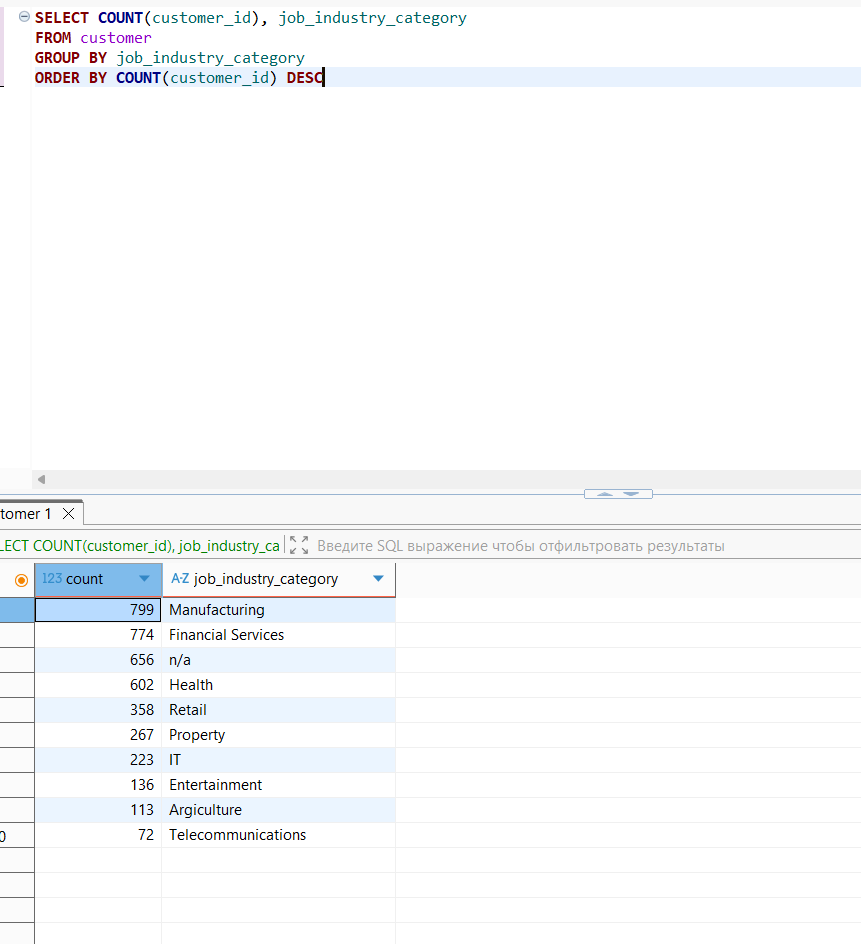

In [ ]:
Задание 2

SELECT EXTRACT(YEAR FROM order_date), EXTRACT(MONTH FROM order_date),
c.job_industry_category, SUM(quantity * oi.item_list_price_at_sale)
FROM orders o
JOIN order_items oi ON o.order_id = oi.order_id
JOIN customer c ON o.customer_id = c.customer_id
WHERE order_status = 'Approved'
GROUP BY EXTRACT(YEAR FROM order_date), EXTRACT(MONTH FROM order_date),
c.job_industry_category
ORDER BY EXTRACT(YEAR FROM order_date), EXTRACT(MONTH FROM order_date),
c.job_industry_category


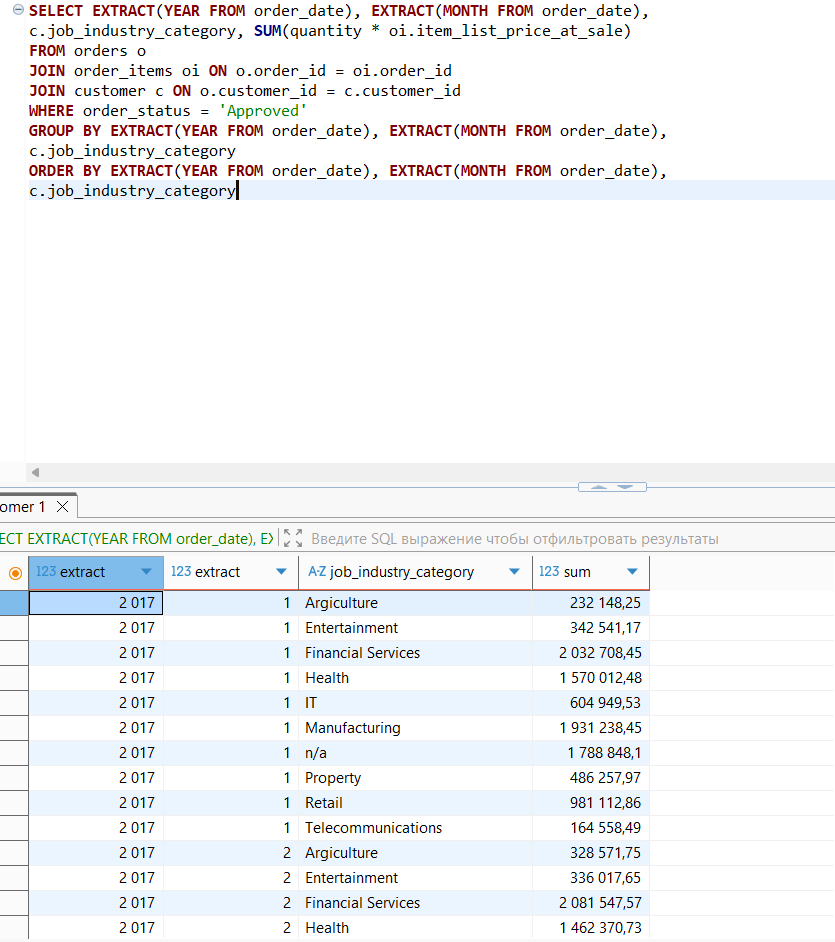

In [ ]:
Задание 3

WITH brands_cte AS (
    select distinct brand
    from product
),
orders_online AS (
    select p.brand, count(o.order_id) as order_count
    from orders o
    join order_items oi on o.order_id = oi.order_id
    join product p on p.product_id = oi.product_id
    join customer c on c.customer_id = o.customer_id
    where order_status = 'Approved'
    and c.job_industry_category = 'IT'
    group by p.brand
)
SELECT bc.brand, COALESCE(oso.order_count, 0) AS online_order_count
FROM brands_cte bc
LEFT JOIN orders_online oso ON bc.brand = oso.brand
ORDER BY online_order_count

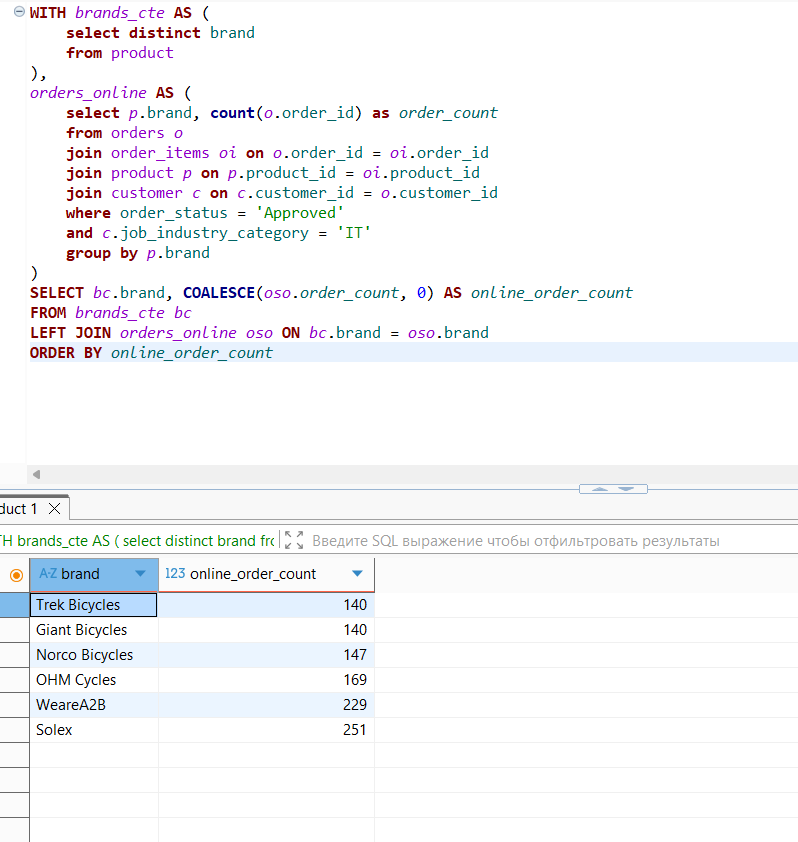

In [ ]:
Задание 4

С GROUP BY

SELECT c.customer_id, c.first_name, c.last_name,
COALESCE(SUM(oi.quantity * oi.item_list_price_at_sale), 0) orders_sum,
COALESCE(MAX(oi.quantity * oi.item_list_price_at_sale), 0) orders_max,
COALESCE(MIN(oi.quantity * oi.item_list_price_at_sale), 0) orders_min,
COUNT(o.order_id) count_order,
CASE
    WHEN COUNT(o.order_id) > 0 THEN
        COALESCE(SUM(oi.quantity * oi.item_list_price_at_sale), 0) / COUNT(o.order_id)
    ELSE 0
END as avg_amount
FROM customer c
LEFT JOIN orders o ON c.customer_id = o.customer_id
LEFT JOIN order_items oi ON o.order_id = oi.order_id
GROUP BY c.customer_id, c.first_name, c.last_name
ORDER BY orders_sum DESC, count_order DESC


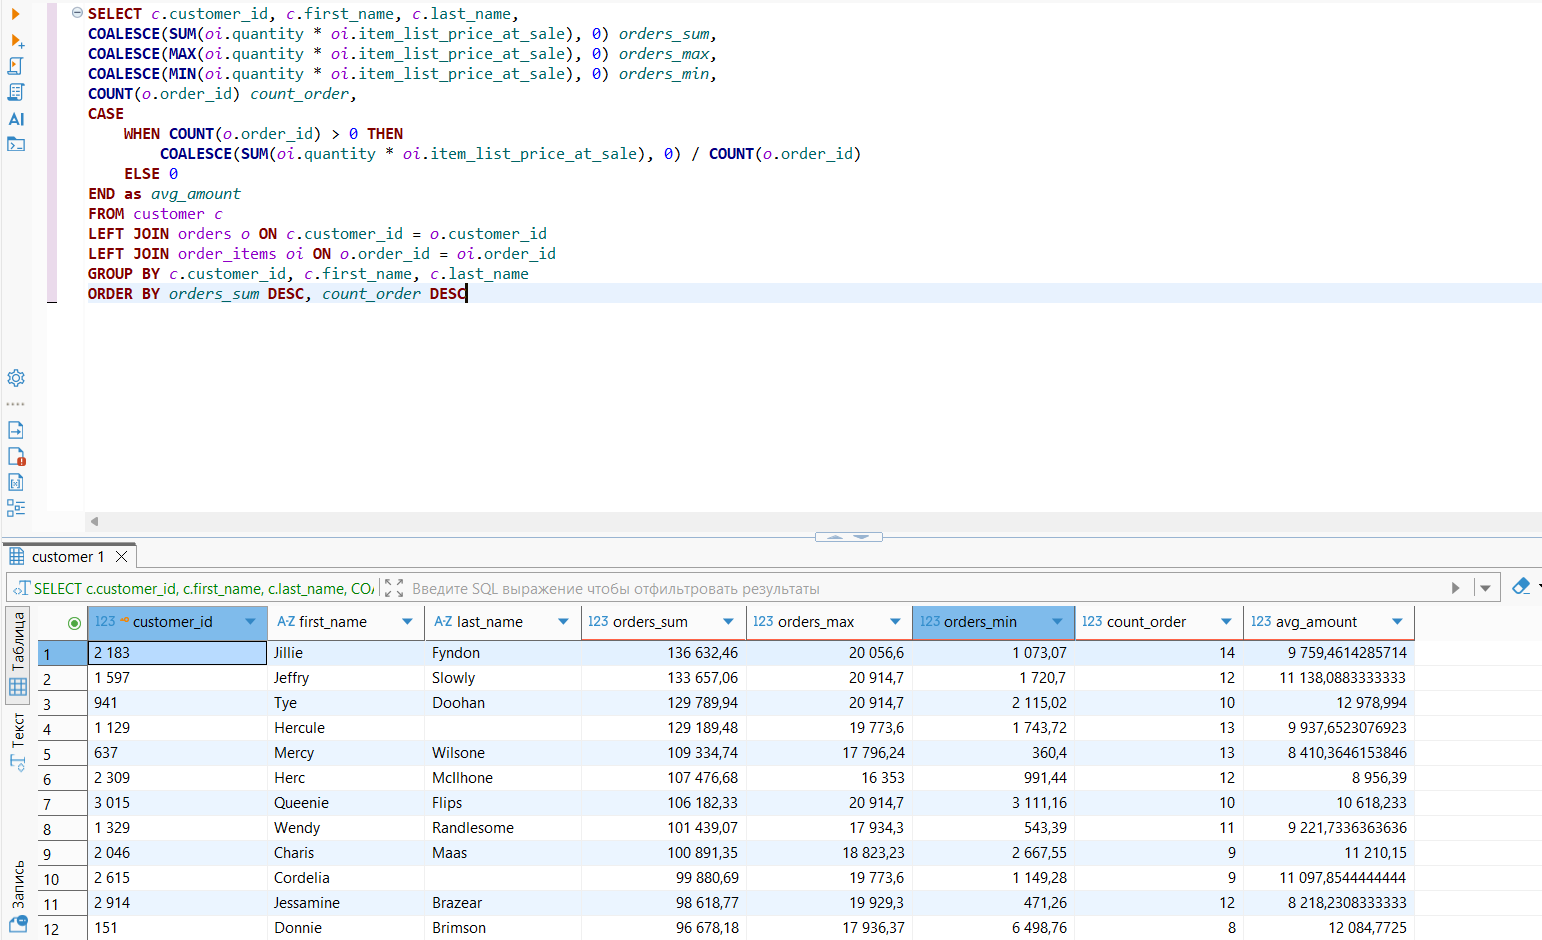

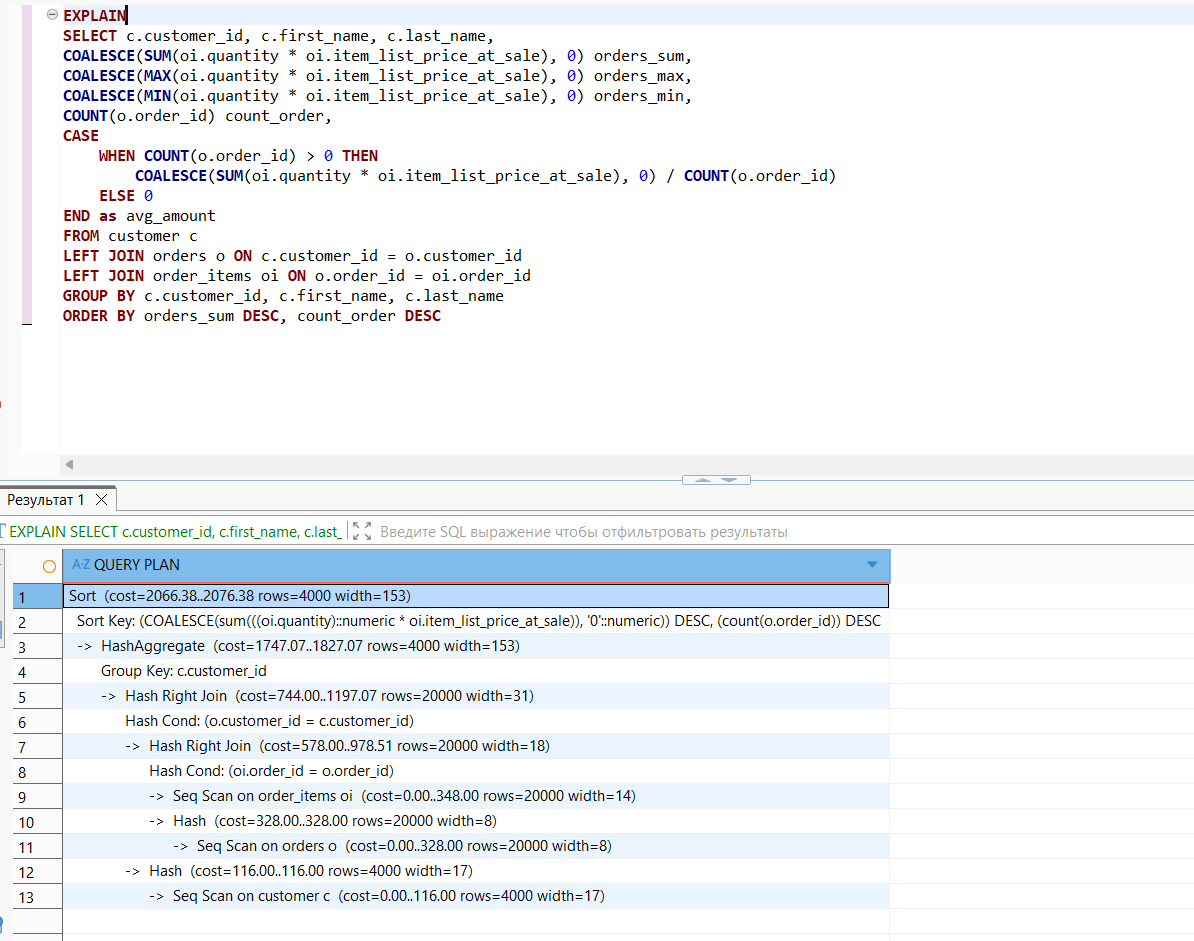

In [ ]:
С оконной функцией

WITH customer_orders AS (
    SELECT c.customer_id, c.first_name, c.last_name,
        o.order_id, SUM(oi.quantity * oi.item_list_price_at_sale) as order_sum
    FROM customer c
    LEFT JOIN orders o ON c.customer_id = o.customer_id
    LEFT JOIN order_items oi ON o.order_id = oi.order_id
    GROUP BY c.customer_id, c.first_name, c.last_name, o.order_id
),
customer_stats AS (
    SELECT
        customer_id, first_name, last_name,
        COALESCE(SUM(order_sum), 0) as order_sum,
        COALESCE(MAX(order_sum), 0) as order_max,
        COALESCE(MIN(CASE WHEN order_sum > 0 THEN order_sum END), 0) as min_order,
        COUNT(order_id) as order_count,
        CASE
            WHEN COUNT(order_id) > 0 THEN COALESCE(SUM(order_sum), 0) / COUNT(order_id)
            ELSE 0
        END as avg_order
    FROM customer_orders
    GROUP BY customer_id, first_name, last_name
)
SELECT * FROM customer_stats
ORDER BY order_sum DESC, order_count DESC


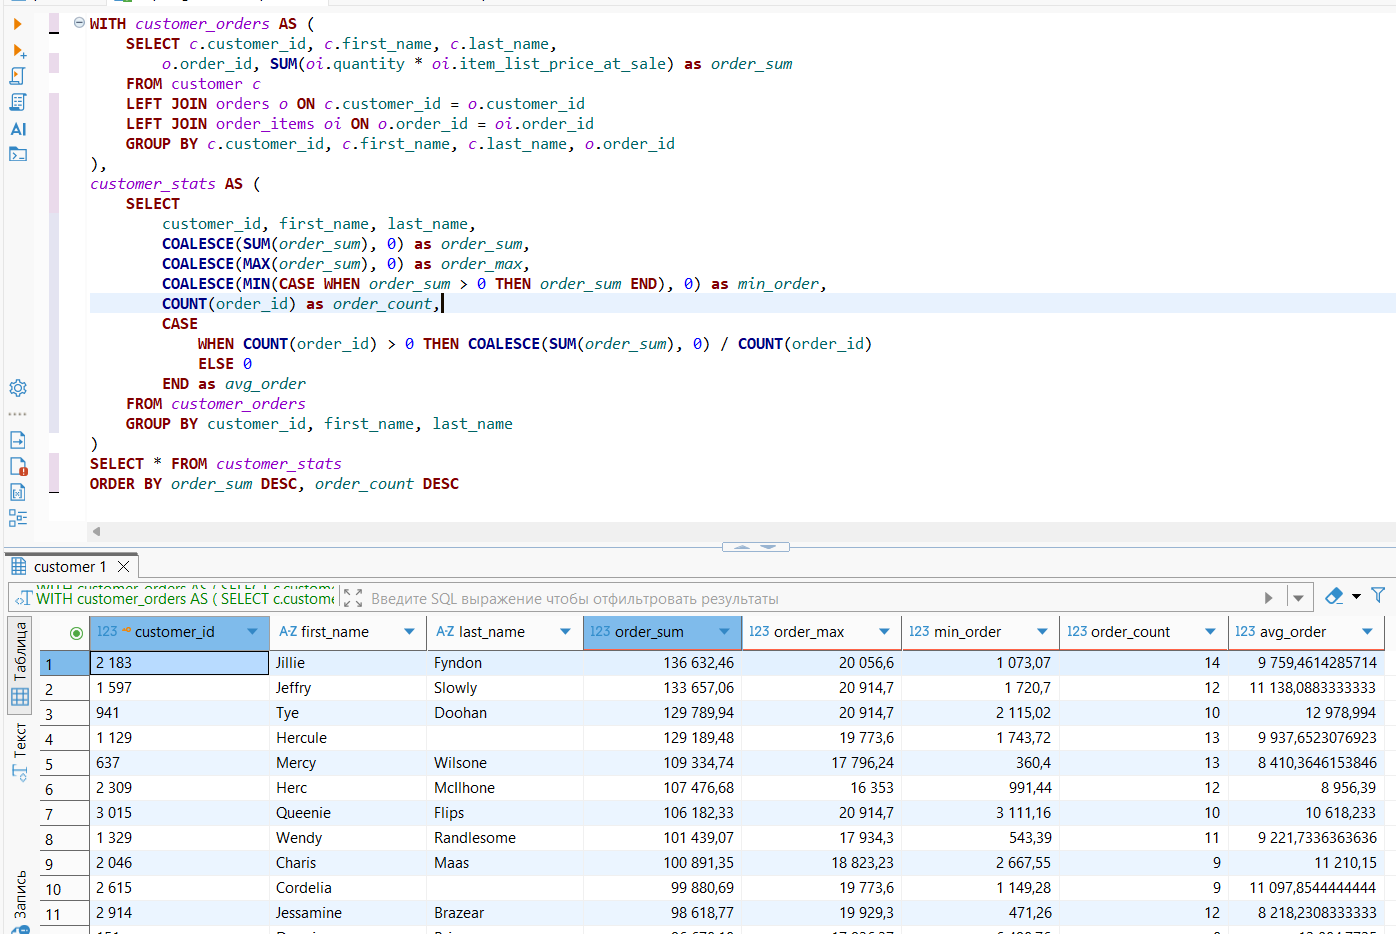

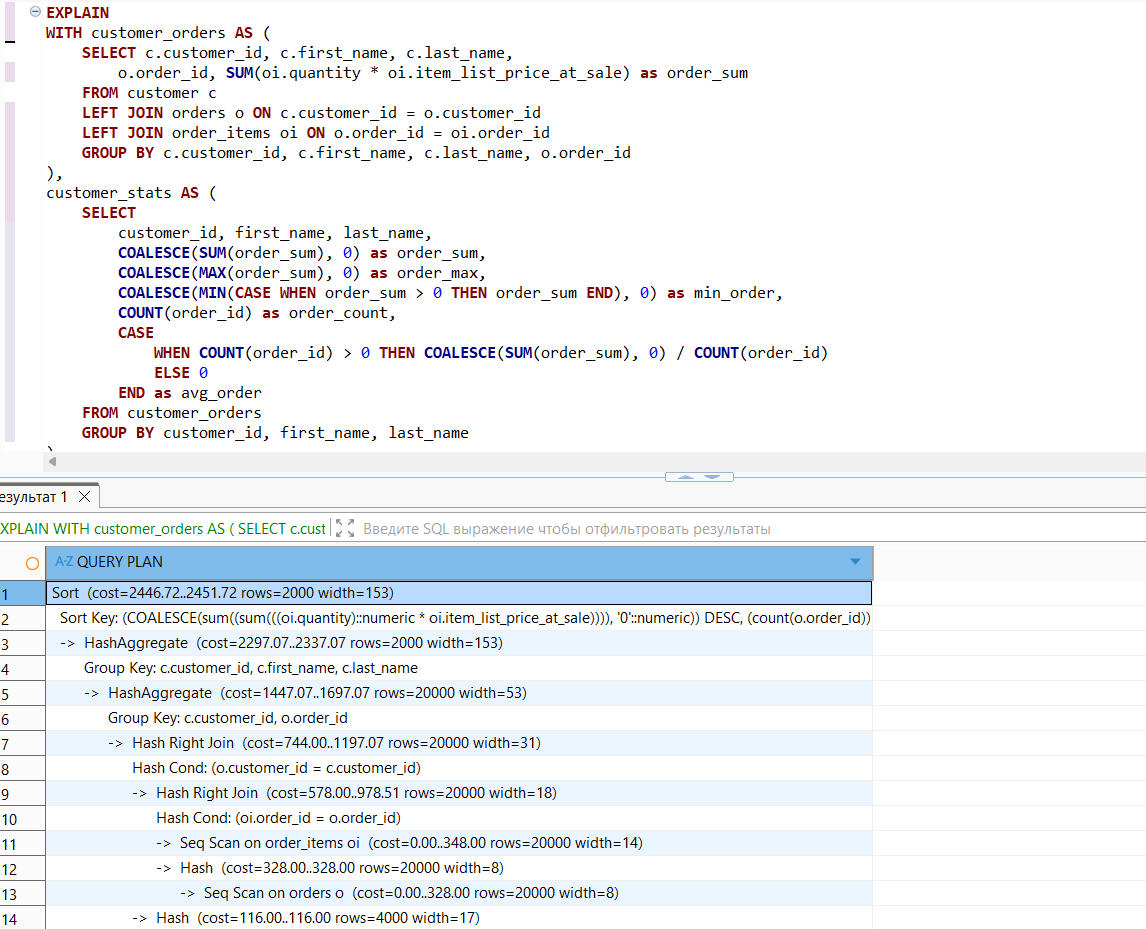

Сравнив запросы с помощью Explain, видим, что немного быстрее выполняется запрос с Group By.



In [ ]:
Задание 5

WITH customer_total AS (
    SELECT c.customer_id, c.first_name, c.last_name, COALESCE(SUM(oi.quantity * oi.item_list_price_at_sale), 0) as total_sum
    FROM customer c
    LEFT JOIN orders o ON c.customer_id = o.customer_id
    LEFT JOIN order_items oi ON o.order_id = oi.order_id
    GROUP BY c.customer_id, c.first_name, c.last_name
),
min_top AS (
    SELECT customer_id, first_name, last_name, total_sum, 'min' as category
    FROM customer_total
    ORDER BY total_sum ASC
    LIMIT 3
),
max_top AS (
    SELECT customer_id, first_name, last_name, total_sum, 'max' as category
    FROM customer_total
    ORDER BY total_sum DESC
    LIMIT 3
)
SELECT * FROM min_top
UNION ALL
SELECT * FROM max_top
ORDER BY category, total_sum


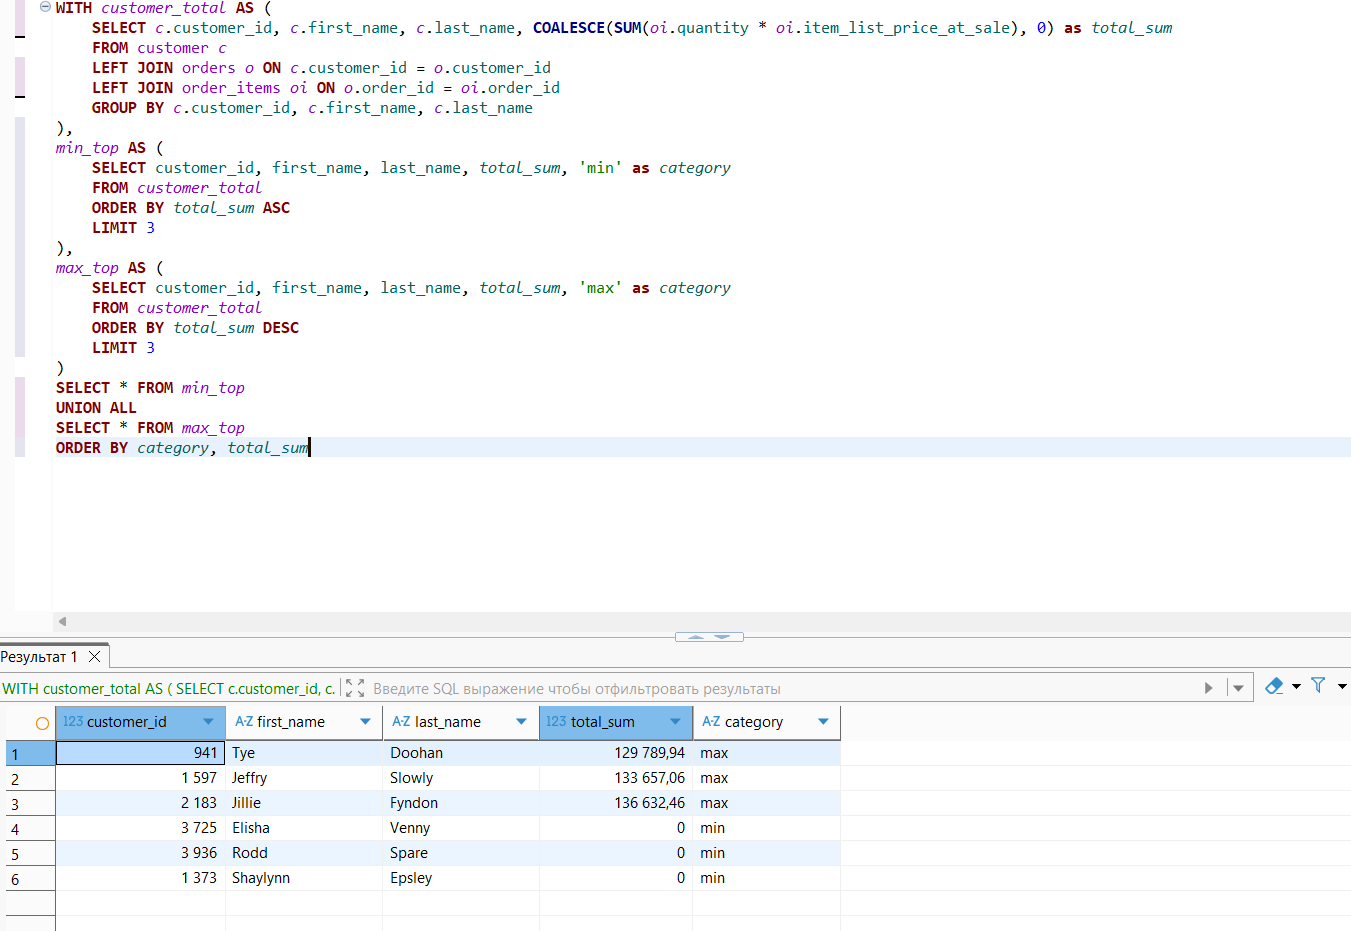

In [ ]:
Задание 6



WITH customer_orders AS (
    SELECT o.order_id, o.customer_id, o.order_date, ROW_NUMBER() OVER (PARTITION BY o.customer_id ORDER BY o.order_date) as order_rank
    FROM orders o
)
SELECT co.order_id, co.customer_id, c.first_name, c.last_name, co.order_date
FROM customer_orders co
JOIN customer c ON co.customer_id = c.customer_id
WHERE co.order_rank = 2


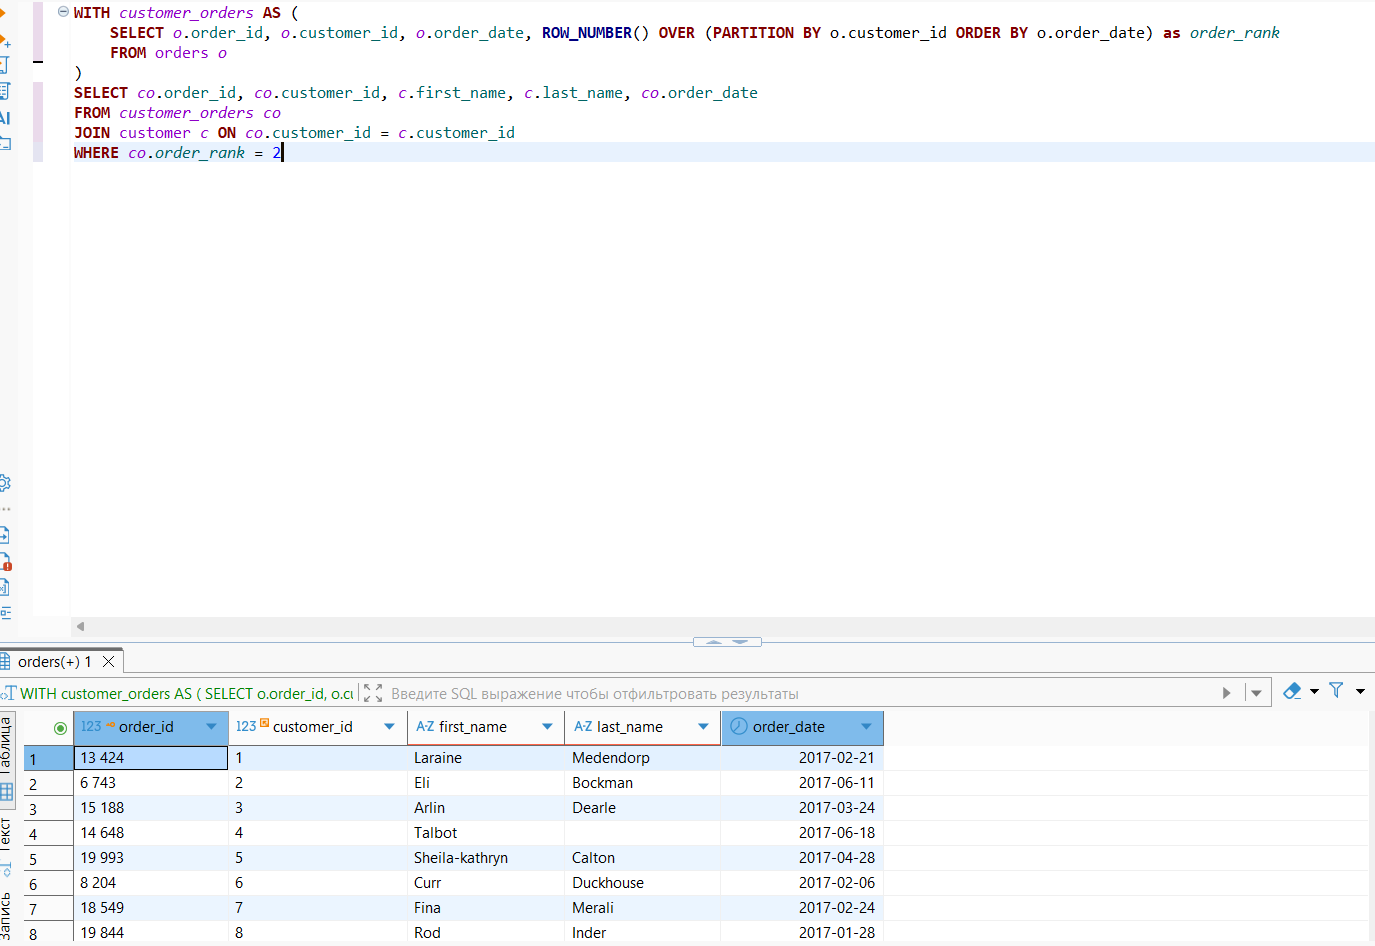

In [ ]:
Задание 7

WITH intervals AS (
    SELECT o.customer_id, o.order_date,
        LEAD(o.order_date) OVER (PARTITION BY o.customer_id ORDER BY o.order_date) as next_order_date,
        LEAD(o.order_date) OVER (PARTITION BY o.customer_id ORDER BY o.order_date) - o.order_date as days_between
    FROM orders o
),
max_intervals AS (
    SELECT
        customer_id,
        MAX(days_between) as max_days
    FROM intervals
    WHERE days_between IS NOT NULL
    GROUP BY customer_id
    HAVING COUNT(*) >= 1
)
SELECT c.customer_id, c.first_name, c.last_name, c.job_title, mi.max_days
FROM max_intervals mi
JOIN customer c ON mi.customer_id = c.customer_id
ORDER BY mi.max_days DESC


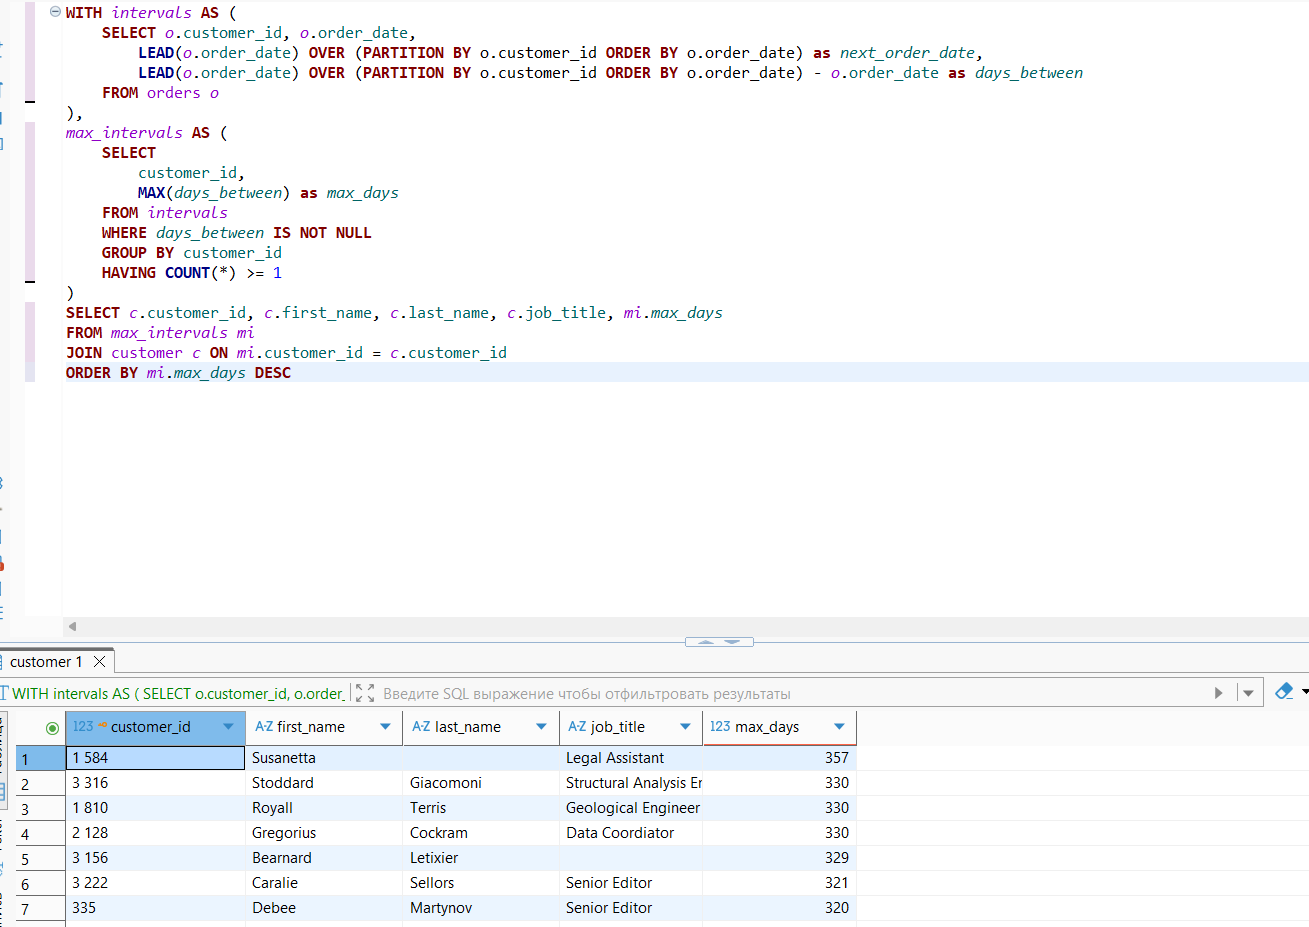

In [ ]:
Задание 8


WITH customer_revenue AS (
    SELECT c.customer_id, c.first_name, c.last_name, c.wealth_segment,
        COALESCE(SUM(oi.quantity * oi.item_list_price_at_sale), 0) as total_revenue,
        ROW_NUMBER() OVER (PARTITION BY c.wealth_segment ORDER BY COALESCE(SUM(oi.quantity * oi.item_list_price_at_sale), 0) DESC) as rank_segment
    FROM customer c
    LEFT JOIN orders o ON c.customer_id = o.customer_id
    LEFT JOIN order_items oi ON o.order_id = oi.order_id
    GROUP BY c.customer_id, c.first_name, c.last_name, c.wealth_segment
)
SELECT customer_id, first_name, last_name, wealth_segment, total_revenue, rank_segment
FROM customer_revenue
WHERE rank_segment <= 5
ORDER BY wealth_segment, rank_segment


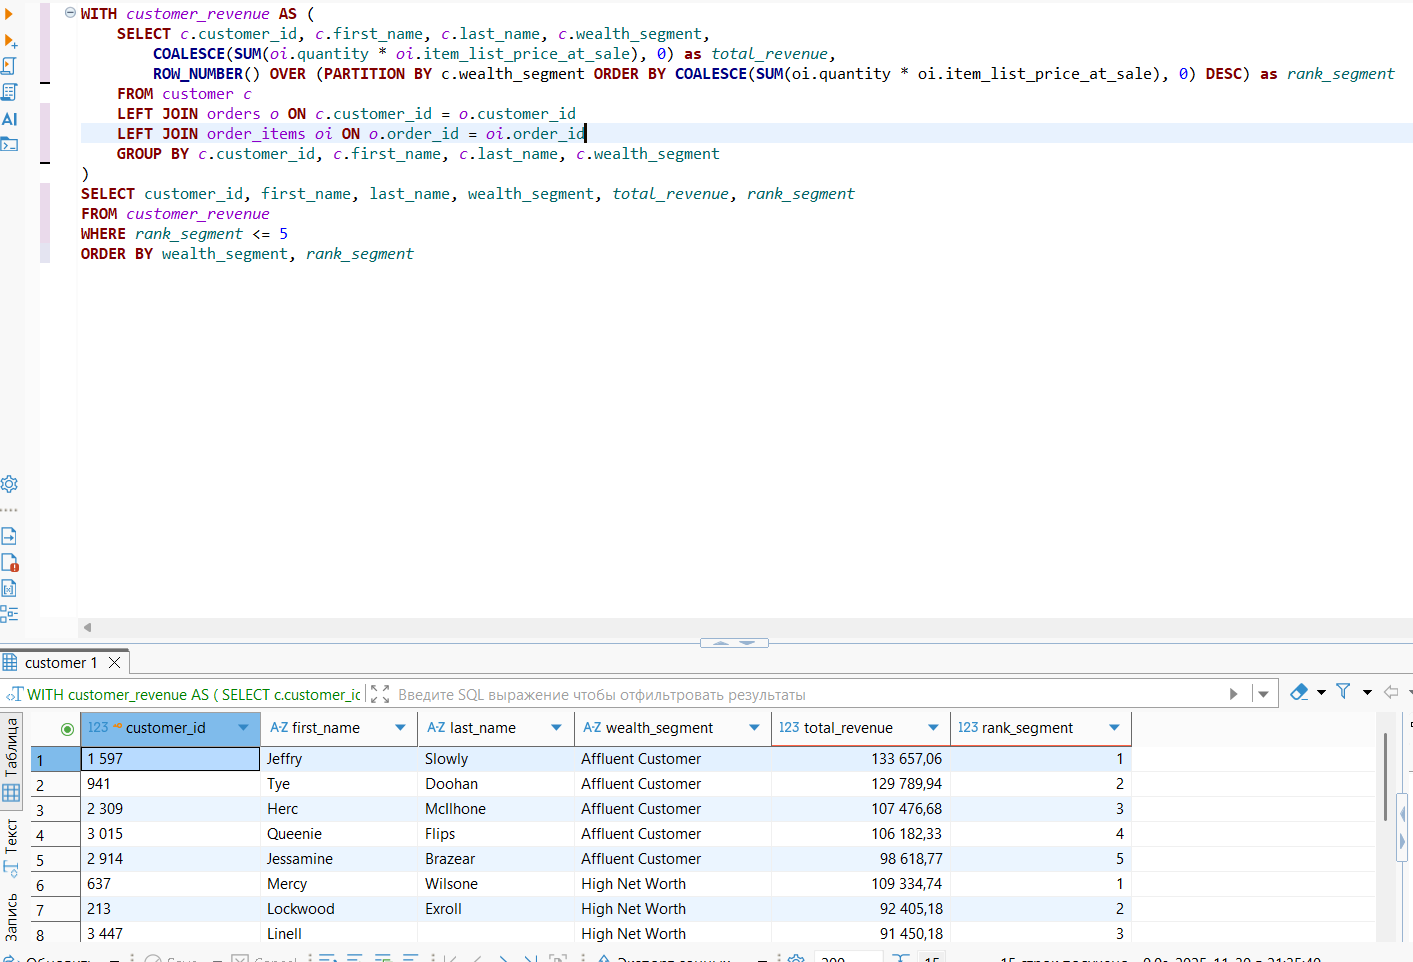